Este colab fue desarrollado por Arnold Charry Armero.

# KNN: K-Nearest Neighbors

El método de K-Nearest Neighbors trata de estimar la probabilidad de $Y$ dado el valor de $X$. Después se clasifica una observación dada a la clase con mayor probabilidad. Para saber cuáles son las probabilidades, se establece el valor de $k$ valores más cercanos, que se encarga de comparar la frecuencia de las clases de los $k$ vecinos y saber cuál es la más concurrida. El valor más frecuente es el determinado para clasificar (predecir) la nueva observación. Matemáticamente se denota de esta manera,

$$ P\left ( Y = j  \right | X = x_{0}) = \frac{1}{K}\sum_{i \epsilon N_{0}}^{}I\left ( y_{i}=j \right ) $$

**Nota:** Como es un algoritmo que se basa en las distancias entre la observación nueva y cada una de las ya memorizadas, las variables de entrenamiento deben ser númericas.

Ahora vamos con la implementación en código,

In [ ]:
# Se importan las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/fake_bills.csv', sep = ';')

In [ ]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Primero se analiza la base de datos,

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [ ]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Se contabiliza la cantidad de personas que obtuvieron billetes falsos,

In [ ]:
df['is_genuine'].value_counts()

,count
is_genuine,
True,1000
False,500


## Preprocesamiento de Datos

Se verifica a ver el tema de los faltantes,

In [ ]:
df.isnull().sum()[df.isnull().sum() != 0]

,0
margin_low,37


In [ ]:
# Se llenan los faltantes con la media
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

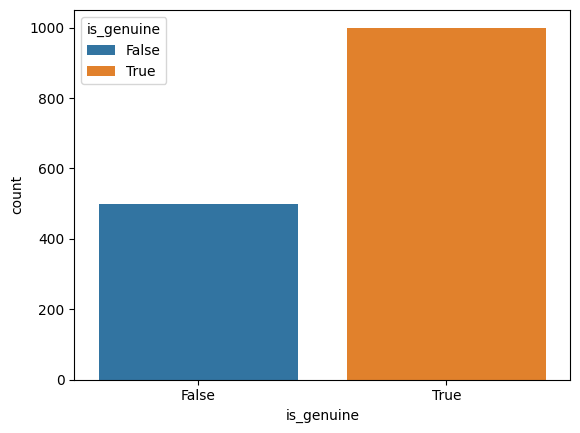

In [ ]:
sns.countplot(data=df,x='is_genuine', hue='is_genuine')
plt.show()

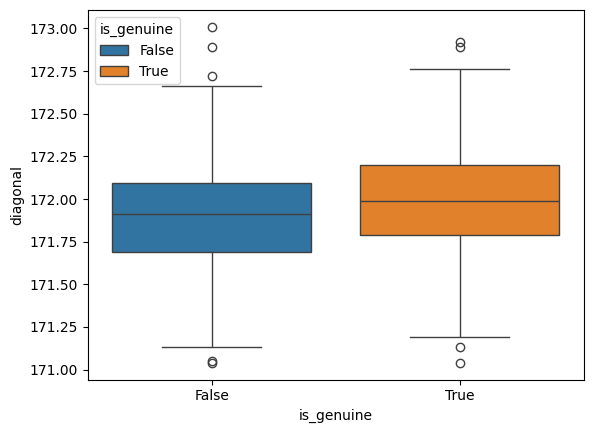

In [ ]:
sns.boxplot(x='is_genuine',y='diagonal',data=df, hue='is_genuine')
plt.show()

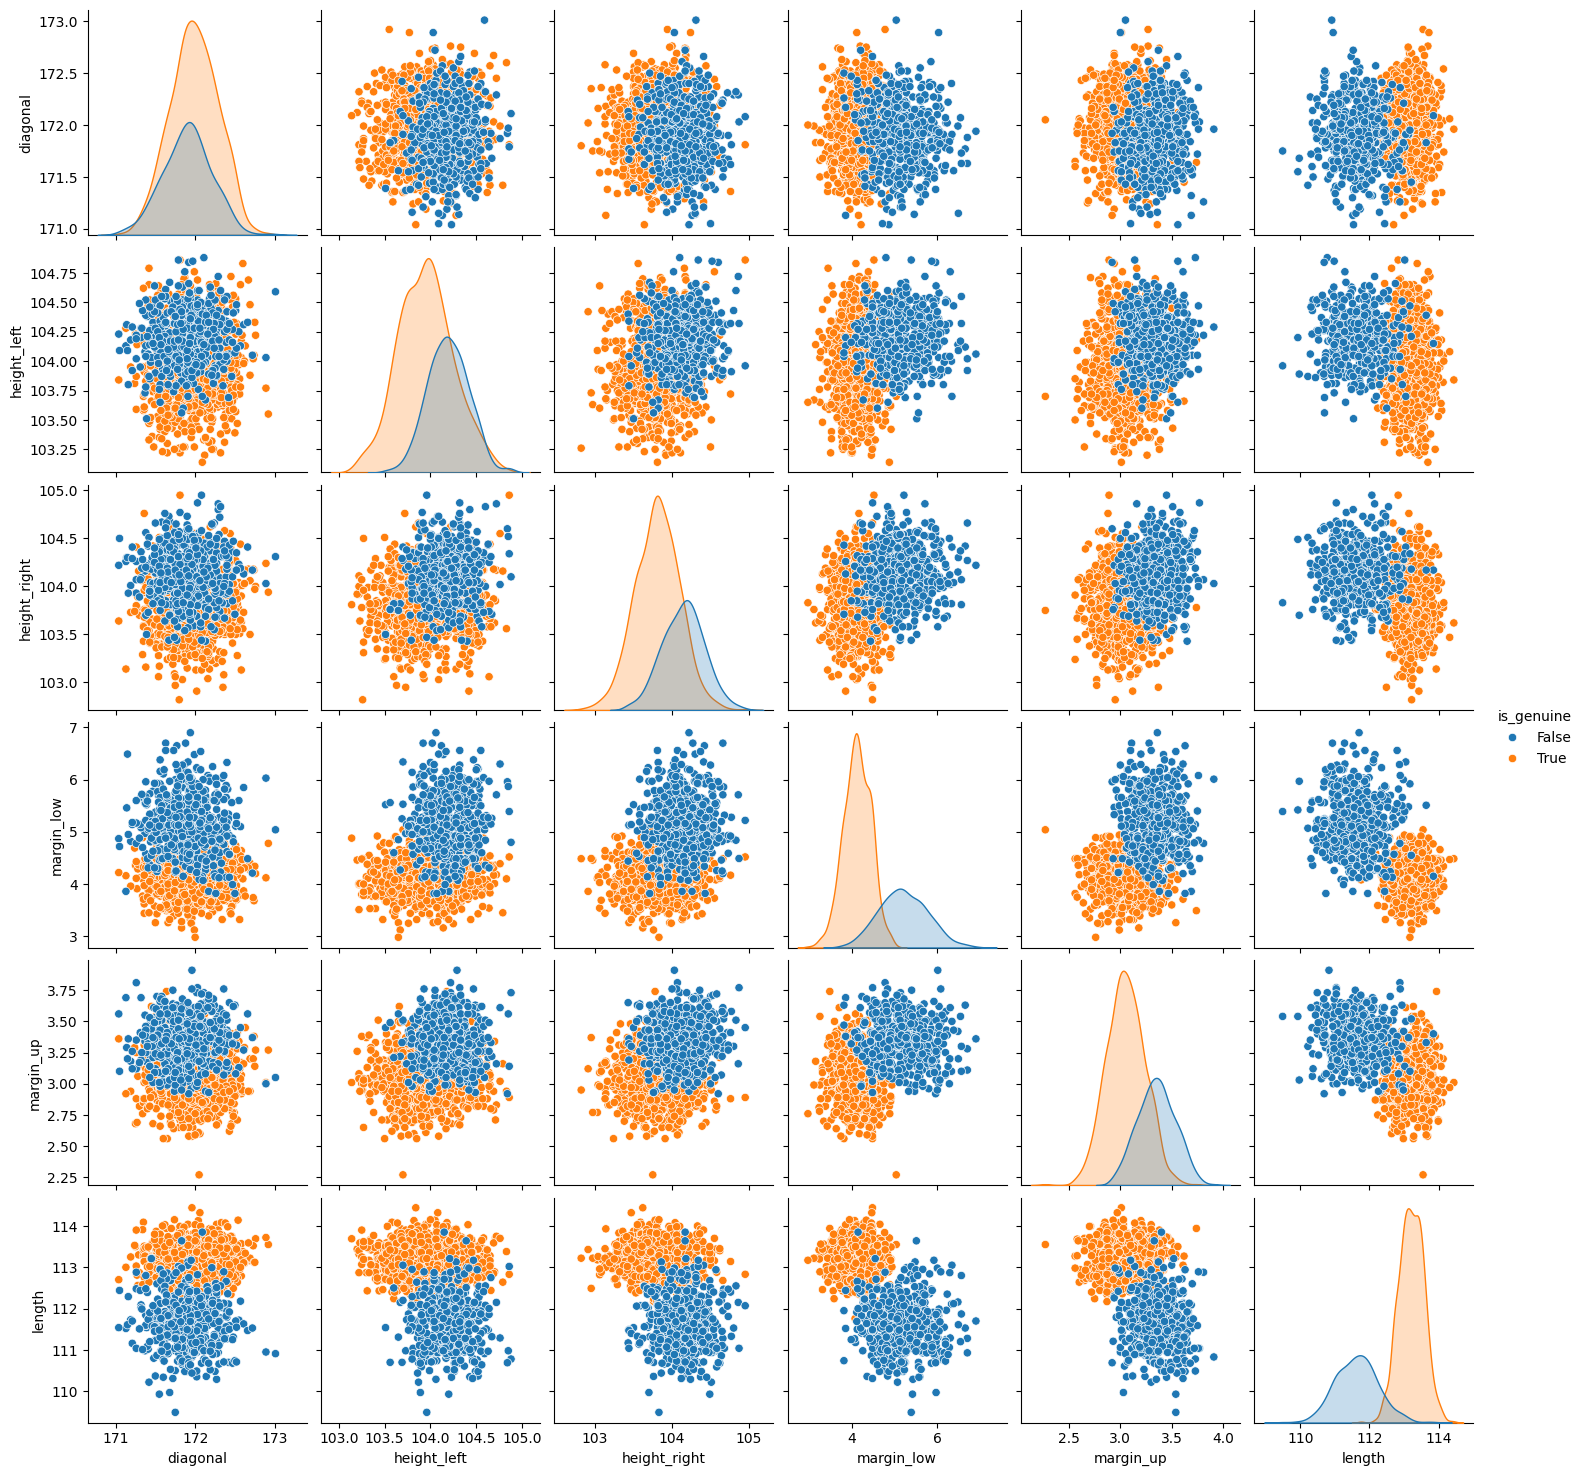

In [ ]:
sns.pairplot(df,hue='is_genuine')
plt.show()

In [ ]:
# Obtenemos las características
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_indices),
                  ('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

Ahora vamos a partir la base de datos en entrenamiento y de prueba. Se estandarizaron los datos, ya que estos se basan en distancias y estas tienen que estar en el mismo rango para que ninguna sesgue el modelo.

## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Escalado de Datos

In [ ]:
# Se escalan las variables
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
# Visualizar el array X
print(X_train)

[[-0.40001244  0.87378926 -1.03436678 -0.73418832  0.74261155  0.5853987 ]
 [-0.10985911 -0.79429321 -1.76512211 -0.97929365 -1.50249314  0.34559263]
 [-0.17433763  1.3074907   0.30535134 -0.15206317 -0.20724043  0.19714125]
 ...
 [-1.85077908 -0.66084661  0.21400692 -0.06014867 -0.12089025  0.8937208 ]
 [-0.56120873  0.94051256 -0.30361144  2.62069083  0.44038592 -1.77840401]
 [-0.36777318  0.10647132  0.54893645  0.59857189  0.44038592 -1.89259737]]


## Entrenamiento del Modelo

Ahora vamos con el modelo de KNN con sus predicciones,

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [ ]:
knn_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

Realizando una predicción,

In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", knn_model.predict(ct.transform([[174.14, 105.41,	102.50,	3.90,	2.94,	116.07]]))[0])

Predicción: True


In [ ]:
# Obtenemos las predicciones
y_pred = knn_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 

## Rendimiento del Modelo

In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9822222222222222


In [ ]:
# Matriz de confusión
confusion_matrix(y_test,y_pred)

array([[155,   6],
       [  2, 287]])

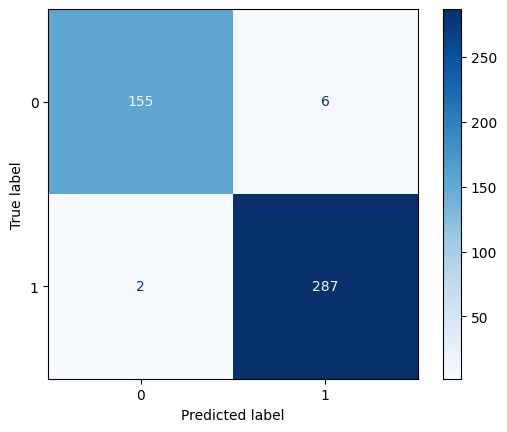

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.96      0.97       161
        True       0.98      0.99      0.99       289

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



## Método del Codo para elegir valores K razonables


In [ ]:
# Se obtienen los errores para diferentes valores de K

test_error_rates = []

for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train,y_train)

    y_pred_test = knn_model.predict(X_test)

    test_error = 1 - accuracy_score(y_test, y_pred_test)
    test_error_rates.append(test_error)

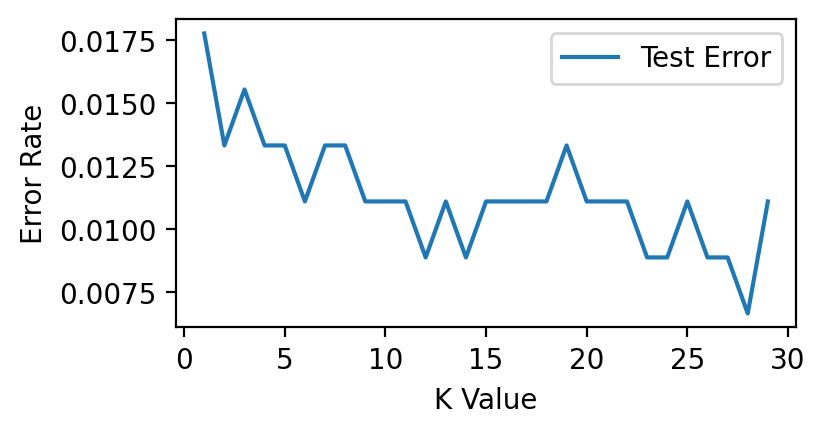

In [ ]:
plt.figure(figsize=(4, 2),dpi=200)
plt.plot(range(1, 30),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")
plt.show()

## Validación Cruzada y Grid Search para encontrar el valor de K

Se mide el accuracy para la diferente selección de datos de entrenamiento y prueba,

In [ ]:
# Aplicar K-fold Cross Validation
accuracies = cross_val_score(estimator = knn_model, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
print(accuracies.mean())

0.9876190476190476


Se conocen los parámetros de KNN para evaluar el GridSearch y así escoger el mejor K.

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
# Parámetros
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [ ]:
# Se establecen los valores de k a probar
k_values = list(range(1, 30, 2))
parameters = {'n_neighbors': k_values}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = knn,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'accuracy')

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29]},
             scoring='accuracy')

In [ ]:
# Se obtienen los mejores parámetros
full_cv_classifier.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
# Se obtiene el mejor resultado
print(full_cv_classifier.best_score_)

0.9895238095238096


In [ ]:
# Se obtienen los resultados de prueba.
full_cv_classifier.cv_results_['mean_test_score']

array([0.98285714, 0.98666667, 0.98761905, 0.98761905, 0.98952381,
       0.98857143, 0.98952381, 0.98857143, 0.98857143, 0.98761905,
       0.98666667, 0.98666667, 0.98666667, 0.98666667, 0.98761905])

Ahora se vuelve a entrenar el modelo, pero con el K óptimo.

In [ ]:
# Entrenamiento del Modelo
model = KNeighborsClassifier(n_neighbors = 9)
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=9)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 

In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9888888888888889


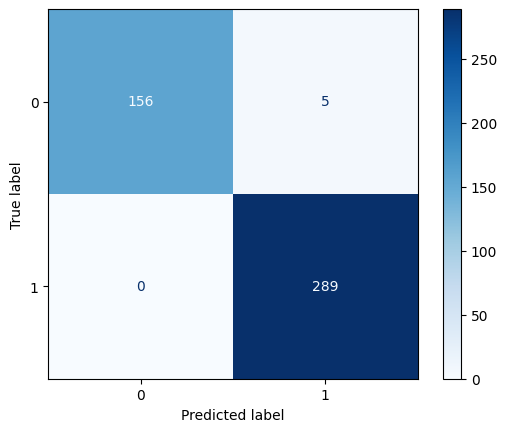

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98       161
        True       0.98      1.00      0.99       289

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.99       450
weighted avg       0.99      0.99      0.99       450



## Referencias

*   Fake bills. (2023, February 18). Kaggle. https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills
*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf

